### Import Libraries

In [117]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from helper_functions import accuracy_fn
from timeit import default_timer as timer
from tqdm.auto import tqdm
import pandas as pd
from pathlib import Path
print(f'PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}')

PyTorch version: 2.2.0
torchvision version: 0.17.0


In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Getting a dataset

In [2]:
# Setup train data
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

# Setup test data
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:08<00:00, 3300191.78it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 288878.61it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2590674.33it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5843647.36it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [16]:
# Get first training sample
img, label = train_data[0]
img, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

#### Input and Output shapes of a computer vision model

In [18]:
# Image shape
img.shape # (color_channels, height, weight)

torch.Size([1, 28, 28])

In [20]:
# Number of samples
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [21]:
# Classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

#### Visualize our data

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

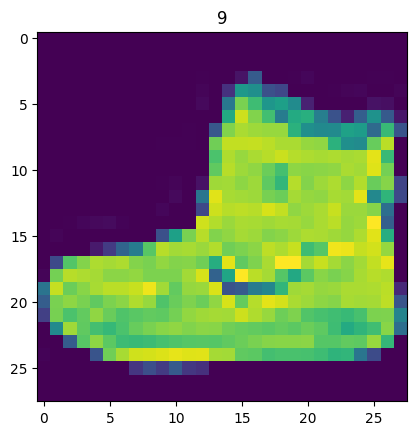

In [24]:
img, label = train_data[0]
print(f'Image shape: {img.shape}')
plt.imshow(img.squeeze())
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

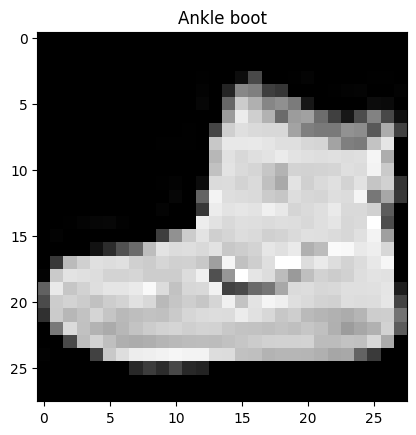

In [25]:
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])

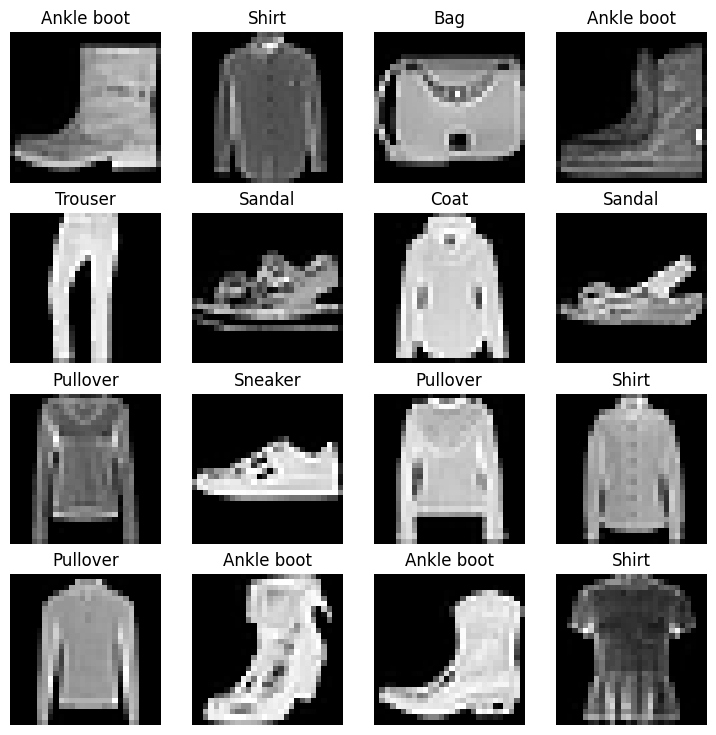

In [26]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols  = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap = 'gray')
    plt.title(class_names[label])
    plt.axis(False)

### Prepare DataLoader

In [28]:
batch_size = 32

train_loader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False
)

print(f'Train loader: {train_loader} Test loader: {test_loader}')
print(f'Length of train loader: {len(train_loader)}')
print(f'Length of test loader: {len(test_loader)}')

Train loader: <torch.utils.data.dataloader.DataLoader object at 0x16b1e59d0> Test loader: <torch.utils.data.dataloader.DataLoader object at 0x16b80a050>
Length of train loader: 1875
Length of test loader: 313


In [29]:
# Lets see what's inside a data loader
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

### Model 0: Build a baseline model

In [30]:
class CVModelV0(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layers_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.layers_stack(x)

In [33]:
torch.manual_seed(42)

model_0 = CVModelV0(
    input_dim=784, # one for every pixel (28 x 28)
    hidden_dim=10,
    output_dim=len(class_names) # one for every class
).to(device)
model_0

CVModelV0(
  (layers_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

#### Setup loss, optimizer and evaluation metrics

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

#### Creating a function to time our experiments

In [38]:
def print_train_time(start, end, device):
    total_time = end - start
    print(f'Train time on {device}: {total_time:.3f} seconds')
    return total_time

#### Creating a training loop and train on batches

In [41]:
torch.manual_seed(42)
train_time_start = timer()

epochs = 3

for epoch in range(epochs):
    print(f'Epoch: {epoch}\n-------------')
    # Training
    train_loss = 0
    for batch, (X, y) in enumerate(train_loader):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch%400 == 0:
            print(f'Looked at {batch * len(X)/len(train_loader.dataset)} samples')
    train_loss /= len(train_loader)

    # Testing
    model_0.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in test_loader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim = 1))
        test_loss /= len(test_loader)
        test_acc /= len(test_loader)
    print(f'\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n')

train_time_end = timer()
total_train_time_model_0 = print_train_time(train_time_start, train_time_end, str(next(model_0.parameters()).device))

Epoch: 0
-------------
Looked at 0.0 samples
Looked at 0.21333333333333335 samples
Looked at 0.4266666666666667 samples
Looked at 0.64 samples
Looked at 0.8533333333333334 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1
-------------
Looked at 0.0 samples
Looked at 0.21333333333333335 samples
Looked at 0.4266666666666667 samples
Looked at 0.64 samples
Looked at 0.8533333333333334 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2
-------------
Looked at 0.0 samples
Looked at 0.21333333333333335 samples
Looked at 0.4266666666666667 samples
Looked at 0.64 samples
Looked at 0.8533333333333334 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Train time on cpu: 4.973 seconds


### Make predictions and get Model 0 results

In [72]:
torch.manual_seed(42)
def eval_mode(model, dataloader, loss_fn, accuracy_fn, device = device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim = 1))
        loss /= len(dataloader)
        acc /= len(dataloader)
    return {
        'model_name': model.__class__.__name__,
        'model_loss': loss.item(),
        'model_acc': acc
    }

model_0_results = eval_mode(model_0, test_loader, loss_fn, accuracy_fn)
model_0_results

{'model_name': 'CVModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

### Model 1: Building a better model with non-linearity

In [63]:
class CVModelV1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU()
        )
    def forward(self, x):
        return self.layer_stack(x)

In [64]:
torch.manual_seed(42)
model_1 = CVModelV1(input_dim=784,
                    output_dim=len(class_names),
                    hidden_dim=10).to(device)
next(model_1.parameters()).device

device(type='cpu')

#### Setup loss, optimizer and evaluation metrics

In [65]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

#### Functionizing training and test loops

In [66]:
def train_step(model, dataloader, loss_fn, optimizer, accuracy_fn, device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim = 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f'Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%')

def test_step(model, dataloader, loss_fn, accuracy_fn, device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss
            test_acc += accuracy_fn(y, y_pred.argmax(dim = 1))
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f'Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%')

In [67]:
torch.manual_seed(42)

train_time_start = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n-------------')
    train_step(model_1, train_loader, loss_fn, optimizer, accuracy_fn, device)
    test_step(model_1, test_loader, loss_fn, accuracy_fn, device)
train_time_end = timer()
total_train_time_model_1 = print_train_time(train_time_start, train_time_end, str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------------
Train loss: 1.08967 | Train accuracy: 61.41%
Test loss: 0.94960 | Test accuracy: 65.23%


 33%|███▎      | 1/3 [00:01<00:03,  1.78s/it]

Epoch: 1
-------------


 67%|██████▋   | 2/3 [00:03<00:01,  1.80s/it]

Train loss: 0.92832 | Train accuracy: 65.84%
Test loss: 0.94834 | Test accuracy: 66.75%
Epoch: 2
-------------


100%|██████████| 3/3 [00:05<00:00,  1.78s/it]

Train loss: 0.73279 | Train accuracy: 73.43%
Test loss: 0.67461 | Test accuracy: 75.64%
Train time on cpu: 5.334 seconds


In [73]:
torch.manual_seed(42)

model_1_results = eval_mode(model_1, test_loader, loss_fn, accuracy_fn)
model_1_results

{'model_name': 'CVModelV1',
 'model_loss': 0.6746115684509277,
 'model_acc': 75.63897763578275}

In [74]:
model_0_results

{'model_name': 'CVModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

Hmm. Non-linearity doesn't improve accuracy. Model may be overfitting.

Overfitting fixes:
1. Use a smaller model
2. Use a larger dataset

<b>In general:
1. For structured data(excel, row col data):
    - Gradient boosted models
    - Random Forest 
    - XGBoost\
    (sklearn.ensemble.XGBoost library)
2. For unstructured data (images, audio, language):
    - CNNs
    - Transformers\
    (torchvision.models, HuggingFace Transformers)</b>

### Model 2: Building a CNN

In [94]:
class CVModelV2(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(input_dim, 
                      hidden_dim, 
                      kernel_size=3, # how big the square going over image is
                      stride = 1, # how many rows/cols should it skip over
                      padding=1), # valid: no padding, same: input_shape, int: specific number
            nn.ReLU(),
            nn.Conv2d(hidden_dim, 
                      hidden_dim, 
                      kernel_size=3, # how big the square going over image is
                      stride = 1, # how many rows/cols should it skip over
                      padding=1), # valid: no padding, same: input_shape, int: specific number
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_dim*7*7,
                      output_dim)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x
    
torch.manual_seed(42)
model_2 = CVModelV2(input_dim=1,hidden_dim=10, output_dim=len(class_names)).to(device)
model_2

CVModelV2(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [95]:
# Lets test the layers
torch.manual_seed(42)

# Create sample batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch, color_channels, height, width]
test_image = images[0]
print(f'Image batch shape: {images.shape}')
print(f'Single image shape: {test_image.shape}')
print(f'Single image pixel values:\n{test_image}')

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

#### Stepping through Conv2d()

In [96]:
torch.manual_seed(42)

conv_layer_1 = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3,
    stride=1,
    padding=0
)

conv_layer_1(test_image.unsqueeze(dim = 0)).shape

torch.Size([1, 10, 62, 62])

In [97]:
conv_layer_2 = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=5,
    stride=2,
    padding=0
)

conv_layer_2(test_image.unsqueeze(dim = 0)).shape

torch.Size([1, 10, 30, 30])

#### Stepping through MaxPool2d()

In [98]:
print(f'Test image original shape: {test_image.shape}')
print(f'Test image unsquuezed: {test_image.unsqueeze(dim=0).shape}')
max_pool_layer = nn.MaxPool2d(kernel_size=2)
test_image_through_conv = conv_layer_1(test_image.unsqueeze(dim=0))
print(f'Shape after going through conv: {test_image_through_conv.shape}')
test_image_through_conv_and_maxpool = max_pool_layer(test_image_through_conv)
print(f'Shape after going through conv and maxpool: {test_image_through_conv_and_maxpool.shape}')

Test image original shape: torch.Size([3, 64, 64])
Test image unsquuezed: torch.Size([1, 3, 64, 64])
Shape after going through conv: torch.Size([1, 10, 62, 62])
Shape after going through conv and maxpool: torch.Size([1, 10, 31, 31])


#### Setup loss function and optimizer for model_2

In [99]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

#### Training and testing model_2

In [100]:
torch.manual_seed(42)

start_time = timer()
epochs = 3
for epoch in range(epochs):
    print(f'Epoch: {epoch}---------------')
    train_step(model_2, train_loader, loss_fn, optimizer, accuracy_fn, device)
    test_step(model_2, test_loader, loss_fn, accuracy_fn, device)
end_time = timer()
total_train_time_model_2 = print_train_time(start_time, end_time, device)

Epoch: 0---------------
Train loss: 0.58884 | Train accuracy: 78.62%
Test loss: 0.38769 | Test accuracy: 85.96%
Epoch: 1---------------
Train loss: 0.36084 | Train accuracy: 87.12%
Test loss: 0.35130 | Test accuracy: 87.14%
Epoch: 2---------------
Train loss: 0.32367 | Train accuracy: 88.12%
Test loss: 0.33189 | Test accuracy: 87.85%
Train time on cpu: 88.549 seconds


In [101]:
model_2_results = eval_mode(
    model=model_2,
    dataloader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_2_results

{'model_name': 'CVModelV2',
 'model_loss': 0.33189156651496887,
 'model_acc': 87.84944089456869}

### Compare model results and training time

In [103]:
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,CVModelV0,0.476639,83.426518
1,CVModelV1,0.674612,75.638978
2,CVModelV2,0.331892,87.849441


In [104]:
compare_results['training_time'] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,CVModelV0,0.476639,83.426518,4.973484
1,CVModelV1,0.674612,75.638978,5.334330
2,CVModelV2,0.331892,87.849441,88.548906


#### Performance-speed tradeoff

Text(0, 0.5, 'model')

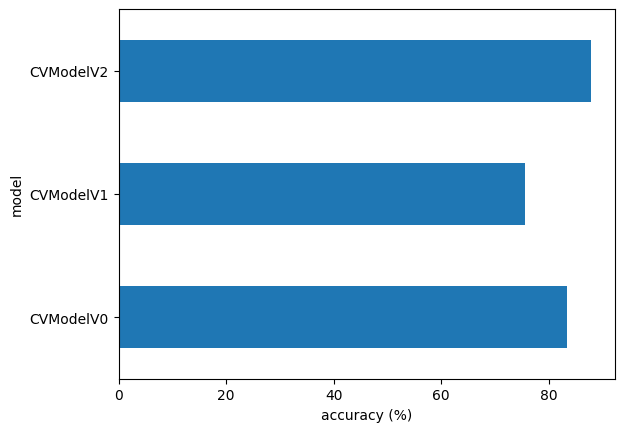

In [105]:
# Visualize model results
compare_results.set_index('model_name')['model_acc'].plot(kind='barh')
plt.xlabel('accuracy (%)')
plt.ylabel('model')

### Make and evaluate random predictions with best model

In [106]:
def make_predictions(model, data, device=device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim = 0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [107]:
import random
torch.manual_seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
print(f'Img shape: {test_samples[0].shape}\nLabel: {test_labels[0]} ({class_names[test_labels[0]]})')

Img shape: torch.Size([1, 28, 28])
Label: 6 (Shirt)


In [108]:
pred_probs = make_predictions(model_2, test_samples)
pred_probs[:2]

tensor([[8.6395e-01, 3.7798e-05, 1.6538e-03, 7.3149e-03, 1.2172e-05, 1.8133e-06,
         1.2671e-01, 2.0812e-06, 3.1459e-04, 9.1457e-07],
        [3.6458e-03, 5.3247e-04, 9.2330e-02, 1.0212e-05, 7.0002e-01, 4.2140e-04,
         2.0253e-01, 4.1428e-06, 2.9635e-04, 2.0860e-04]])

In [109]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([0, 4, 6, 8, 5, 3, 3, 8, 3])

In [110]:
test_labels, pred_classes

([6, 4, 6, 8, 5, 3, 3, 6, 3], tensor([0, 4, 6, 8, 5, 3, 3, 8, 3]))

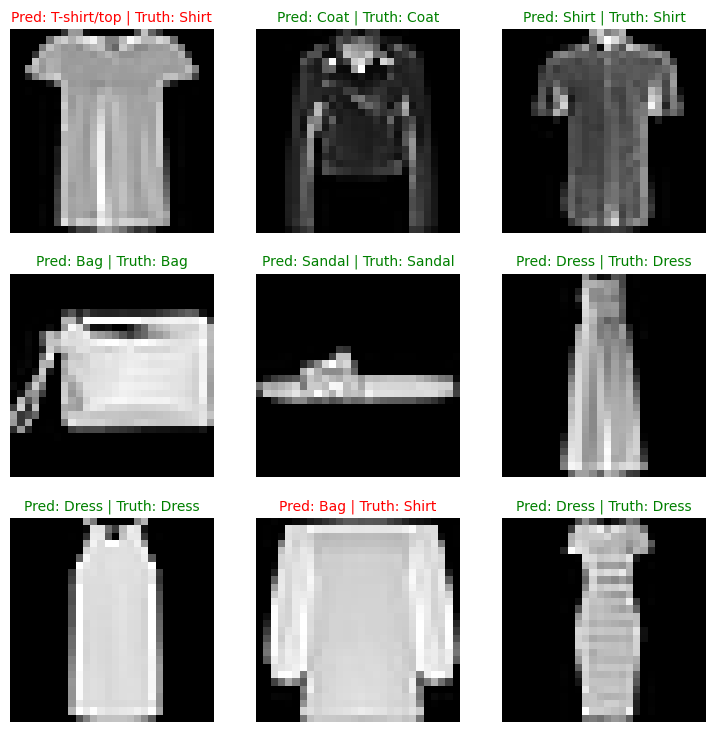

In [111]:
# Plot predictions
plt.figure(figsize=(9,9))
nrows, ncols = 3, 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap='gray')
    predlabel = class_names[pred_classes[i]]
    truthlabel = class_names[test_labels[i]]
    titletext = f'Pred: {predlabel} | Truth: {truthlabel}'
    if predlabel == truthlabel:
        plt.title(titletext, fontsize=10, c='g')
    else:
        plt.title(titletext, fontsize=10, c='r')
    plt.axis(False)

### Making confusion matrix

In [112]:
ypreds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_loader, desc='Making predictions'):
        X, y = X.to(device), y.to(device)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        ypreds.append(y_pred.cpu())
y_pred_tensor = torch.cat(ypreds)

Making predictions: 100%|██████████| 313/313 [00:00<00:00, 367.16it/s]


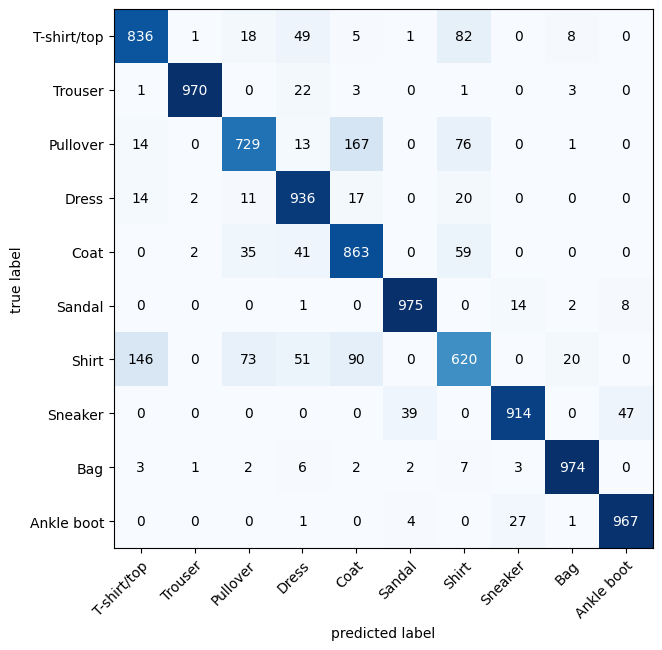

In [116]:
confmat = ConfusionMatrix(num_classes=len(class_names),
                          task = 'multiclass')
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = test_data.targets)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

### Save and load best model

In [118]:
model_path = Path('models')
model_path.mkdir(parents=True, exist_ok=True)
model_name = '03_pytorch_cvmodel2.pth'
model_save_path = model_path / model_name
print(f'Saving model to: {model_save_path}')
torch.save(obj=model_2.state_dict(), f=model_save_path)

Saving model to: models/03_pytorch_cvmodel2.pth


In [120]:
loaded_model_2 = CVModelV2(input_dim=1, output_dim=10, hidden_dim=10)
loaded_model_2.load_state_dict(torch.load(f=model_save_path))
loaded_model_2 = loaded_model_2.to(device)

In [122]:
# Evaluate
torch.manual_seed(42)
loaded_model_2_results = eval_mode(loaded_model_2, test_loader, loss_fn, accuracy_fn)
loaded_model_2_results

{'model_name': 'CVModelV2',
 'model_loss': 0.33189156651496887,
 'model_acc': 87.84944089456869}

In [123]:
model_2_results

{'model_name': 'CVModelV2',
 'model_loss': 0.33189156651496887,
 'model_acc': 87.84944089456869}

In [124]:
# check results close to each other
torch.isclose(torch.tensor(model_2_results['model_loss']),
              torch.tensor(loaded_model_2_results['model_loss']),
              atol=1e-08,
              rtol=0.0001)

tensor(True)